---
title: "Teaching AI Some Geography"
author: "Abdullah Zeeshan"
date: "2022-11-14"
categories: [fast.ai, experiments]
toc: true
description: Building an image classifier
fig-align: center
fig-cap-location: bottom
sidebar: false
---


[Lesson 1](https://course.fast.ai/Lessons/lesson1.html) of the [Practical Deep Learning for Coders](https://course.fast.ai/) course offered by [fast.ai](fast.ai) gets hands-on on building an image classifier of your choice pretty quickly without any hastles from the get-go!

I tried to build an image classifier that could classify the 7 continents based on their *map* images. And boy let me tell you, I was unbelievably amazed by its results. 

::: {layout-ncol=1}
![](world.png)
Image by <a href="https://pixabay.com/users/pfüderi-199315/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1974699">Pfüderi</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1974699">Pixabay</a>
:::

Let me show you how I did it! Feel free to try yourself on [Colab](https://colab.research.google.com/) or any platform of your choice!

---

# Continents Classifier

## Setting Up

### Install Packages

We begin by installing `fastbook` and `duckduckgo_search`. The formers allows us to access the fast.ai library that will help us build our image classifier and the latter allows us to access DuckDuckGo search engine features to search, get, and download our images for training.  



In [ ]:
!pip install -Uqq fastbook duckduckgo_search

### Import Relevant Libraries

We import the relevant libraries. More about them [here](https://docs.fast.ai/).



In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *


### Setup A System For Getting Images

Here, we create a handy little function that can search for a specific `term` on DuckDuckGo image searches and get its URLs 

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

For example, if our `term` is `africa continent map`, the above function gets the first popped up URL of the image of `africa continent map` as shown below.

In [ ]:
urls = search_images('africa continent map', max_images=1)
urls[0]

Searching for 'africa continent map'


'https://cdn.onestopmap.com/wp-content/uploads/2015/05/464-map-africa-continent-political-shaded-relief.jpg'

Once, we get the URLs of an image, let us setup a way through which we can actually *download* the URLs we obtained and *view* them. We will storing the downloaded files in `jpg` formats. 

The following snippets do that for us.

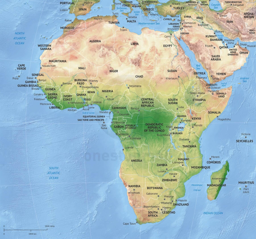

In [ ]:
dest = 'africa.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

The Africa continent looks good. Let us have sneak peak on the remaining 6 continents just to make sure that DuckDuckGo is getting the right images for us.

Searching for 'antarctica continent map'


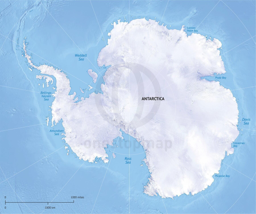

In [ ]:
download_url(search_images('antarctica continent map', max_images=1)[0], 'antarctica.jpg', show_progress=False)
Image.open('antarctica.jpg').to_thumb(256,256)

Searching for 'asia continent map'


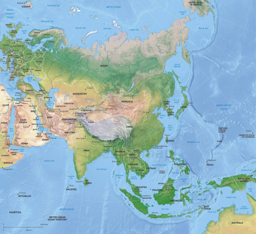

In [ ]:
download_url(search_images('asia continent map', max_images=1)[0], 'asia.jpg', show_progress=False)
Image.open('asia.jpg').to_thumb(256,256)

Searching for 'australia continent map'


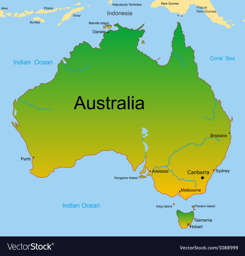

In [ ]:
download_url(search_images('australia continent map', max_images=1)[0], 'australia.jpg', show_progress=False)
Image.open('australia.jpg').to_thumb(256,256)

Searching for 'europe continent map'


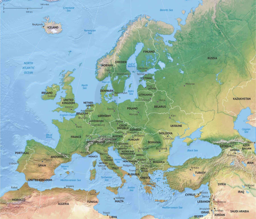

In [ ]:
download_url(search_images('europe continent map', max_images=1)[0], 'europe.jpg', show_progress=False)
Image.open('europe.jpg').to_thumb(256,256)

Searching for 'north america continent map'


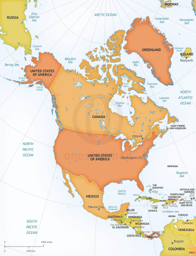

In [ ]:
download_url(search_images('north america continent map', max_images=1)[0], 'north_america.jpg', show_progress=False)
Image.open('north_america.jpg').to_thumb(256,256)

Searching for 'south america continent map'


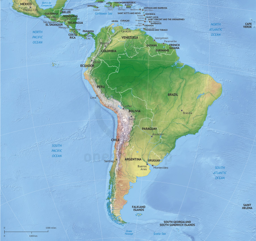

In [ ]:
download_url(search_images('south america continent map', max_images=1)[0], 'south_america.jpg', show_progress=False)
Image.open('south_america.jpg').to_thumb(256,256)

Everything, looks good!

Now that everything is setup, let us create our classifier. Generally, the following steps are taken when building an image classifier model.

---

## Get Image Data

Let us go on and get our image data.

In [ ]:
searches = ['africa', 'antarctica', 'asia', 'australia', 'europe', 'north america', 'south america']
path = Path('which_continent_is_it')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} continent map'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'africa continent map'
Searching for 'antarctica continent map'


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


Searching for 'asia continent map'
Searching for 'australia continent map'


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'europe continent map'
Searching for 'north america continent map'
Searching for 'south america continent map'


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


Sometimes, we might get a few broken images. We can track and discard them as follows.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

---

## Create `DataBlock`

Next we create a `DataBlock` that helps us *put* our images into the model.

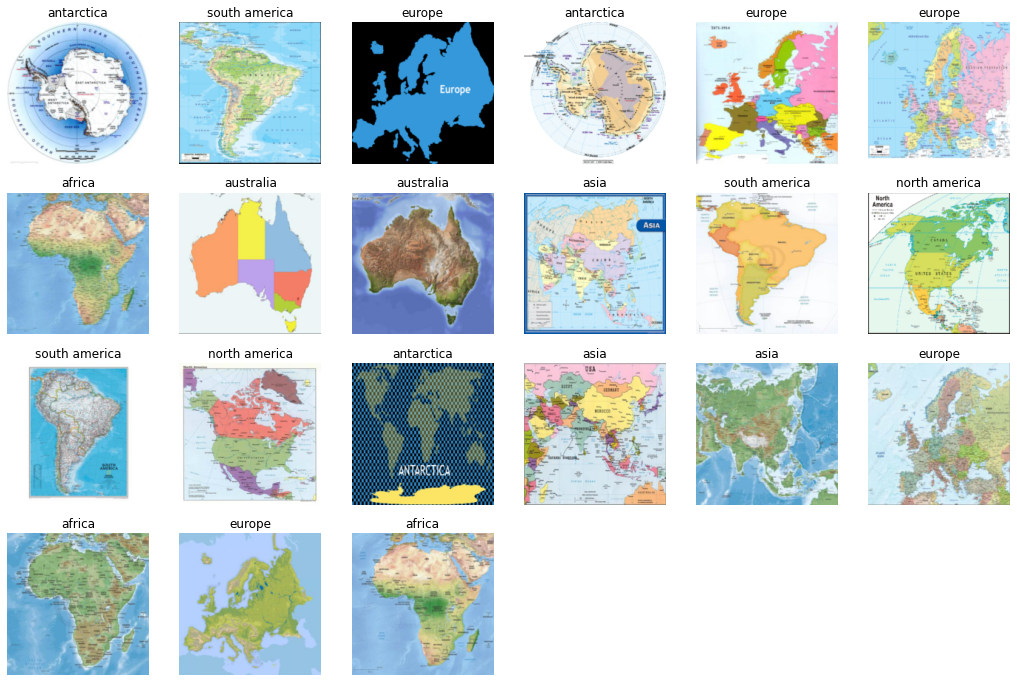

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=21)

---

## Create The Learner

Now, we create the actual model that will learn from the image data we gave it.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.544921,1.500386,0.538462,00:44


epoch,train_loss,valid_loss,error_rate,time
0,1.187040,0.556937,0.179487,01:04
1,0.718358,0.290570,0.089744,01:04
2,0.497790,0.240653,0.076923,01:02


---

## Test The Model

Our model is ready to be tested!

Let us input the images we stored at the beginning and see its results. 

In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('africa.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[0]:.4f}")

This is: africa.
Probability: 0.9926


In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('antarctica.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[1]:.4f}")

This is: antarctica.
Probability: 0.9998


In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('asia.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[2]:.4f}")

This is: asia.
Probability: 1.0000


In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('australia.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[3]:.4f}")

This is: australia.
Probability: 0.9995


In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('europe.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[4]:.4f}")

This is: europe.
Probability: 0.9992


In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('north_america.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[5]:.4f}")

This is: north america.
Probability: 0.9999


In [ ]:
which_continent_is_it,_,probs = learn.predict(PILImage.create('south_america.jpg'))
print(f"This is: {which_continent_is_it}.")
print(f"Probability: {probs[6]:.4f}")

This is: south america.
Probability: 0.9978


Looks pretty impressive isn't it?!

If you have any ideas of your own feel free to try them out. 

---